Importing all the dependencies


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

####Preprocessing

Load all the images and labels and preprocess them, convert to numpy arrays and append them to the respective lists and converting those to numpy arrays

In [3]:
path = "E:/Face-Mask-Detection-try/Face Data/dataset/"
imagePaths = list(paths.list_images(path))
images = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    images.append(image)
    labels.append(label)
images = np.array(images, dtype="float32")
labels = np.array(labels)

In [5]:
np.unique(labels)

array(['E:/Face-Mask-Detection-try/Face Data/dataset/Face_Mask',
       'E:/Face-Mask-Detection-try/Face Data/dataset/No_Mask'],
      dtype='<U54')

In [4]:
print(images.shape)
print(labels.shape)

(1951, 224, 224, 3)
(1951,)


In [6]:
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

# Perform the train test split by forming giving 20% dataset to test model.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,
    test_size=0.20, stratify=labels)

Training image generator for data augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

Keras Functional API has been used to made the architecture of the model.

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
X = baseModel.output
X = AveragePooling2D(pool_size=(7, 7))(X)
X = Flatten()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(2, activation="softmax")(X)
model = Model(inputs=baseModel.input, outputs=X)

9412608/9406464 [==============================] - 6s 1us/step


In [11]:
for layer in baseModel.layers:
	layer.trainable = False

Final Architecture of our model.

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


Defining few parameters

In [13]:
batch_size = 128
epochs = 15

Defining the optimzer and compiling the model.

In [14]:
optimizer = Adam(lr=1e-4, decay=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Training the model.

In [15]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
            steps_per_epoch=len(X_train) // batch_size,
            validation_data=(X_test, y_test),
            validation_steps=len(X_test) // batch_size,
            epochs=epochs)

Epoch 1/15
12/12 [==============================] - 185s 15s/step - loss: 0.6917 - accuracy: 0.6432 - val_loss: 0.2906 - val_accuracy: 0.9309
Epoch 2/15
12/12 [==============================] - 111s 9s/step - loss: 0.2599 - accuracy: 0.9127 - val_loss: 0.1170 - val_accuracy: 0.9795
Epoch 3/15
12/12 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.95 - 92s 8s/step - loss: 0.1459 - accuracy: 0.9581 - val_loss: 0.0654 - val_accuracy: 0.9898
Epoch 4/15
12/12 [==============================] - 136s 11s/step - loss: 0.0934 - accuracy: 0.9791 - val_loss: 0.0431 - val_accuracy: 0.9974
Epoch 5/15
12/12 [==============================] - 224s 19s/step - loss: 0.0655 - accuracy: 0.9888 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 243s 20s/step - loss: 0.0543 - accuracy: 0.9860 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 7/15
12/12 [==============================] - 140s 12s/step - loss: 0.0437 - accuracy: 0.9902 - val_los

We need to find the index of the label with corresponding largest predicted probability for each image in text set.

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=encoder.classes_))

                                                        precision    recall  f1-score   support

E:/Face-Mask-Detection-try/Face Data/dataset/Face_Mask       1.00      1.00      1.00       191
  E:/Face-Mask-Detection-try/Face Data/dataset/No_Mask       1.00      1.00      1.00       200

                                              accuracy                           1.00       391
                                             macro avg       1.00      1.00      1.00       391
                                          weighted avg       1.00      1.00      1.00       391



Saving the model.h5 file so that it can loaded later to use for mask detection.

In [17]:
model.save("model", save_format="h5")

Plot the train and validation loss for our model using matplotlib library.

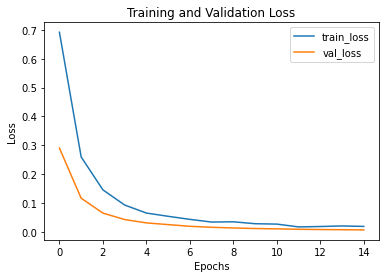

In [18]:
plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [19]:
prototxtPath = 'E:/Face-Mask-Detection-try/Face Data/deploy.prototxt'
weightsPath = 'E:/Face-Mask-Detection-try/Face Data/res10_300x300_ssd_iter_140000.caffemodel'
face_model = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("model")

In [38]:
image = cv2.imread('E:/Face-Mask-Detection-try/Face Data/people1.jpg')
# image = cv2.imread('/content/drive/My Drive/maskclassifier/test/people2.jpg')
height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_model.setInput(blob)
detections = face_model.forward()			#detecting the faces

In [25]:
import matplotlib.pyplot as plt

Then Opencv functions are used to create bounding boxes, put text and show the image.

Number of person with mask : 3
Number of person without mask : 0


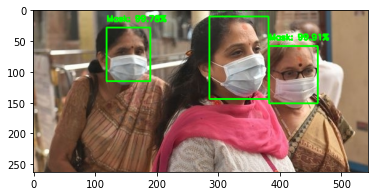

In [39]:
import cv2
import matplotlib.pyplot as plt
threshold = 0.2
person_with_mask = 0;
person_without_mask = 0;
for i in range(0, detections.shape[2]):
    score = detections[0, 0, i, 2]
    if score > threshold:
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        X_start, Y_start, X_end, Y_end = box.astype("int")
        X_start, Y_start = (max(0, X_start), max(0, Y_start))
        X_end, Y_end = (min(width - 1, X_end), min(height - 1, Y_end))

        face = image[Y_start:Y_end, X_start:X_end]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)	

        mask, withoutMask = model.predict(face)[0]

        if mask > withoutMask:
            label = "Mask"
            person_with_mask += 1
        else: 
            label = "No Mask"
            person_without_mask += 1

        if label == "Mask":
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(image, label, (X_start, Y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (X_start, Y_start), (X_end, Y_end), color, 2)
print("Number of person with mask : {}".format(person_with_mask))
print("Number of person without mask : {}".format(person_without_mask))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))